In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix, classification_report,
    mean_squared_error, mean_absolute_error, r2_score
)

# Models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Persistence
import joblib


# Data Overview

In [16]:
df = pd.read_csv("my-projects/Titanic/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# feature engineering
### extract name titles


0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object
Axes(0.125,0.11;0.775x0.77)


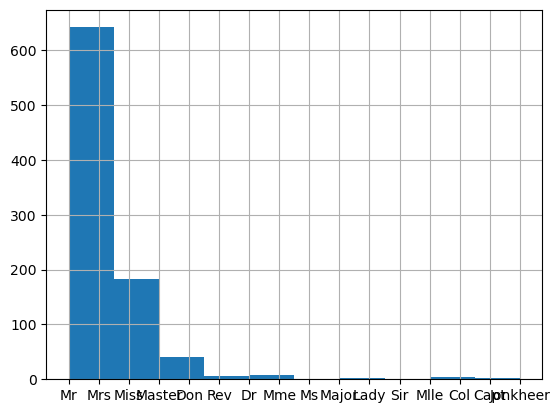

In [8]:
df['Title'] = df['Name'].str.extract(r',\s*([A-Za-z]+)\.')
print(df['Title'])
print(df['Title'].hist())

In [21]:
X = df.drop("Survived", axis=1)
X = X.drop(columns=['Name'])
y = df["Survived"]

# Missing Values

In [22]:
numeric_selector = selector(dtype_include=np.number)
categorical_selector = selector(dtype_exclude=np.number)

numeric_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_prep = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric_prep, numeric_selector),
    ("cat", categorical_prep, categorical_selector)
])


model = Pipeline(steps=[
    ("preprocessor", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# model

In [23]:
# Fit and predict
model.fit(X, y)
predictions = model.predict(X)


from sklearn.model_selection import cross_val_score
import numpy as np

# 10-fold cross-validation accuracy
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')

print("Accuracy scores per fold:", scores)
print("Mean accuracy: {:.4f}".format(np.mean(scores)))
print("Standard deviation: {:.4f}".format(np.std(scores)))

Accuracy scores per fold: [0.84444444 0.82022472 0.75280899 0.88764045 0.94382022 0.83146067
 0.83146067 0.78651685 0.8988764  0.82022472]
Mean accuracy: 0.8417
Standard deviation: 0.0528


# submission

In [26]:
test_df = pd.read_csv('my-projects/Titanic/test.csv')

# Predict on test.csv
test_predictions = model.predict(test_df)

# Save submission file
submission = pd.DataFrame({
    "PassengerId": test_df["PassengerId"],  # replace with your ID column name
    "Survived": test_predictions
})
submission.to_csv("submission.csv", index=False)